我们将按以下顺序执行此操作：

关于卷帘窗理念的技术介绍
我们将使用滚动窗口作为特征提取器（第一个用例）
我们将使用滚动窗口作为平滑器/降噪器（第二个用例）
我们将使用滚动窗口来提取信号的波峰和波谷（第三个用例）
我们将使用滚动窗口来执行傅里叶变换（第四个用例）

让我们定义一下我们的信号：信号是一个离散对象 y[t]，其中 t 是我们的索引，可以从 0 到 len（signal）-1（t≥0 和 t≤len（y）-1）。对于每个位置 t，滚动窗口覆盖线段 y[t]，y[t+1],...,y[t+n−1]。例如，第一个窗口是：


图片由作者制作
漂亮，我们定义了窗户。现在我们必须用它做点什么。

应用滚动窗口的结果是：


图片由作者制作
现在，谁是 O，谁是 M？这取决于您实际对滚动车窗执行的操作。你在做rolling_mean吗？如果是这种情况，M_0 是一个点，O（w_0） 只是从 0 到 n-1 的所有点的平均运算。如果你正在做一个短时傅里叶变换，那么对于给定的窗口，你将得到整个频率向量。所以 M_0 的维数远大于 1，O 是短时傅里叶变换操作（稍后会详细介绍）。

无论您的案例研究是什么，M_0都将是您滚动窗口结果的第一个条目。

下一步是什么？我们通过移动 s 步 （stride） 来识别下一个窗口，并执行相同的操作。例如，如果步幅 s = 1（最大重叠），我们将得到：


图片由作者制作
如果 stride = n （最大步幅），则我们有：


图片由作者制作
并且 M_1 = O（w_1）.

滚动窗口作为特征提取器
假设您没有一个信号，但您有多个信号。每个信号都可以来自源 1,2,3,...,k。

来自同一源的信号具有相似的平均值、标准偏差或峰峰值距离。来自两个不同来源的信号具有完全不同的数据位。

例如，来自源 1 的信号和来自源 k 的信号在信号的第一个位具有完全不同的平均值，在信号的最后一个位具有相似的平均值。

在这种情况下，实现简单的机器学习分类算法（例如 Logistic Regression、Random Forest、SVC 等）非常有用。
尽管如此，将这些算法应用于整个信号是一种浪费。使用滚动窗口提取特征后，执行此操作要简单得多.
我的意思是，你获取信号，通过一个滚动窗口运行它，该窗口提取每个给定窗口的统计特征（例如平均值、标准、峰到峰值距离），然后使用这些特征代替长信号。这可以大大减少执行 ML 任务需要考虑的点数，同时保留保持高性能所需的所有信息。

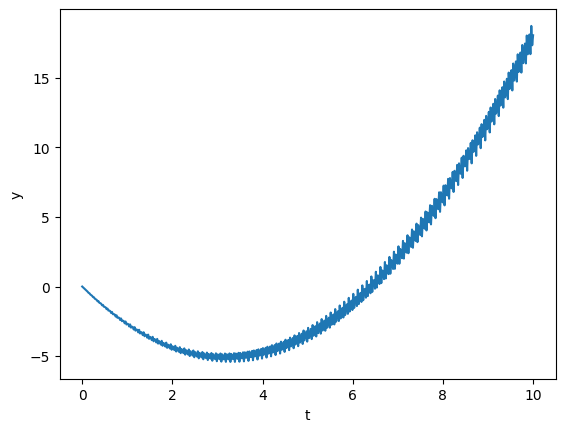

In [1]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 10, 500)
quadratic_signal = 0.5 * x**2
high_freq_disturbance = x* 0.1*np.sin(10_000 * 2 * np.pi * x)
middle_component = np.random.choice(np.linspace(-10,10,1000))
combined_signal = np.array(high_freq_disturbance+middle_component*x+quadratic_signal)
plt.plot(x,combined_signal)
plt.xlabel('t')
plt.ylabel('y')
plt.show()

In [2]:
import numpy as np
import pandas as pd

def extract_features_per_window(signal, window_size, stride):
    """
    Extracts features for each window in the signal and stores them in a single row.
    
    Parameters:
    signal (np.array): The input signal to extract features from.
    window_size (int): The size of the rolling window.
    stride (int): The step size for the window to move forward.

    Returns:
    dict: A dictionary where each window's features are stored in unique columns.
    """
    features = {}

    # Counter to track window number
    window_count = 1

    # Apply rolling window
    for start in range(0, len(signal) - window_size + 1, stride):
        window = signal[start:start + window_size]
        
        # Extract features for the current window
        features[f"mean_{window_count}"] = np.mean(window)
        features[f"std_{window_count}"] = np.std(window)
        features[f"peak_to_peak_{window_count}"] = np.ptp(window)  # peak-to-peak value
        features[f"energy_{window_count}"] = np.sum(window**2)  # signal energy (sum of squares)
        
        # Move to next window
        window_count += 1

    return features


def feature_extractor(signals,window_size,stride):
    feature = {}
    i=0
    for signal in signals:
        feature[f'Signal {i}'] = extract_features_per_window(signal,window_size,stride)
        i=i+1
    return feature


x = np.linspace(0, 10, 500)
quadratic_signal = 0.5 * x**2

high_freq_disturbance = x* 0.1*np.sin(10_000 * 2 * np.pi * x)
middle_component = np.random.choice(np.linspace(-10,10,1000))
combined_signal = np.array(high_freq_disturbance+middle_component*x+quadratic_signal)

# Define window size and stride
window_size = 100  # e.g., a window size of 50 data points
stride = 50  # e.g., move the window forward by 10 points at a time

# Apply feature extraction to the entire signal
windowed_features = extract_features_per_window(combined_signal, window_size, stride)

# Convert the result to a single-row DataFrame for better presentation
windowed_features_df = pd.DataFrame([windowed_features])

# Display the single row of features
windowed_features_df

,mean_1,std_1,peak_to_peak_1,energy_1,mean_2,std_2,peak_to_peak_2,energy_2,mean_3,std_3,...,peak_to_peak_7,energy_7,mean_8,std_8,peak_to_peak_8,energy_8,mean_9,std_9,peak_to_peak_9,energy_9
0,7.59948,4.623224,15.863343,7912.629332,16.106141,5.202395,17.882436,28647.269855,25.616979,5.781785,...,27.922546,549773.78922,88.23417,8.688767,30.234453,786076.350606,103.770006,9.27374,32.506733,1.085422e+06


In [3]:
signals = []
for _ in range(1000):
    # Add high-frequency disturbance (noise or sinusoidal wave)
    high_freq_disturbance = x* 0.1*np.sin(10_000 * 2 * np.pi * x)
    middle_component = np.random.choice(np.linspace(-10,10,1000))
    signals.append(high_freq_disturbance+middle_component*x+quadratic_signal)
signals = np.array(signals)
feature_signals_dict = feature_extractor(signals,window_size=100,stride=50)
feature_signals_df = pd.DataFrame(feature_signals_dict).T
feature_signals_df.head()

,mean_1,std_1,peak_to_peak_1,energy_1,mean_2,std_2,peak_to_peak_2,energy_2,mean_3,std_3,...,peak_to_peak_7,energy_7,mean_8,std_8,peak_to_peak_8,energy_8,mean_9,std_9,peak_to_peak_9,energy_9
Signal 0,-6.500793,3.606462,12.529836,5526.687105,-12.236831,3.031580,10.680796,15893.051333,-16.968693,2.460635,...,2.007026,66871.820665,-25.564999,0.736757,2.946892,65411.200754,-24.271864,1.219614,5.160749,59061.083323
Signal 1,0.787658,0.669529,2.377312,106.867498,2.413691,1.243489,4.462584,737.216857,5.043901,1.822364,...,14.711740,67292.034489,33.257952,4.733074,17.023647,112849.335009,41.913159,5.318810,19.295927,178500.262013
Signal 2,6.487346,3.975185,13.661542,5788.775012,13.870639,4.554446,15.680635,21313.760988,22.258109,5.133987,...,25.765680,439185.322457,79.258461,8.041819,28.077586,634657.453788,93.670929,8.626945,30.349866,884866.704505
Signal 3,5.236195,3.246383,11.184516,3795.673555,11.355699,3.825745,13.203609,14358.823039,18.479380,4.405476,...,23.339205,329614.267204,69.160788,7.314341,25.651112,483671.423984,82.309467,7.899643,27.923392,683725.271169
Signal 4,0.112434,0.305234,1.244960,10.580936,1.056422,0.857850,3.153058,185.193391,3.004587,1.433782,...,13.402214,44840.211345,27.808414,4.342620,15.714121,79216.624449,35.781576,4.928301,17.986401,130460.935728


平滑滚动窗口
我在这里要展示的方法称为 Savitzky-Golay 滤波器。这是我非常喜欢的方法，因为它简单、非常优雅，并且在需要平滑信号的情况下非常有用。

此方法使用滚动窗口，并为每个滚动窗口拟合多项式。例如，如果您有从 0 到 100 的数据，则对该数据集进行多项式拟合，然后从特定窗口上所做的拟合中提取数据，根据多项式拟合替换值，然后转到下一个窗口。

数学可能有点棘手（不是太多，我会说是一个充满笔和纸的夜晚），但实现非常简单，所以让我们开始吧。

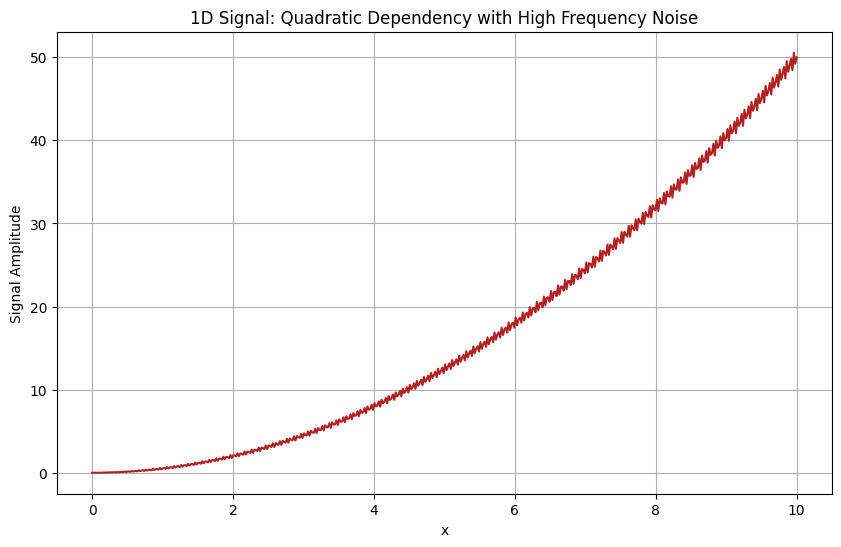

In [4]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
x = np.linspace(0, 10, 500)

quadratic_signal = 0.5 * x**2

# Add high-frequency disturbance (noise or sinusoidal wave)
high_freq_disturbance = x* 0.1*np.sin(10_000 * 2 * np.pi * x)

# Combine the quadratic signal and high-frequency disturbance
combined_signal = quadratic_signal + high_freq_disturbance

# Plot the combined signal
plt.figure(figsize=(10, 6))
plt.plot(x, combined_signal, color='firebrick')
plt.title("1D Signal: Quadratic Dependency with High Frequency Noise")
plt.xlabel("x")
plt.ylabel("Signal Amplitude")
plt.grid(True)

In [5]:
savgol_filter(combined_signal, 5, 2)

array([-6.09282467e-04,  1.00922084e-03,  1.74370579e-03,  1.51337105e-03,
        2.66291445e-03,  6.44128924e-03,  5.17690058e-03,  1.19933603e-02,
        1.13046590e-02,  1.65431641e-02,  2.14049992e-02,  2.15739532e-02,
        3.22600578e-02,  3.11198961e-02,  4.05129229e-02,  4.63446509e-02,
        4.80661455e-02,  6.25415497e-02,  6.09614299e-02,  7.45706223e-02,
        8.12604466e-02,  8.46547170e-02,  1.02835618e-01,  1.00831627e-01,
        1.18714633e-01,  1.26152669e-01,  1.31340837e-01,  1.53140079e-01,
        1.50732869e-01,  1.72943266e-01,  1.81021683e-01,  1.88125604e-01,
        2.13452783e-01,  2.10667553e-01,  2.37254774e-01,  2.45867930e-01,
        2.55010044e-01,  2.83771618e-01,  2.80638086e-01,  3.11647356e-01,
        3.20691934e-01,  3.31995108e-01,  3.64094514e-01,  3.60646883e-01,
        3.96119154e-01,  4.05494298e-01,  4.19081675e-01,  4.54419440e-01,
        4.50696367e-01,  4.90668261e-01,  5.00275702e-01,  5.16270546e-01,
        5.54744412e-01,  

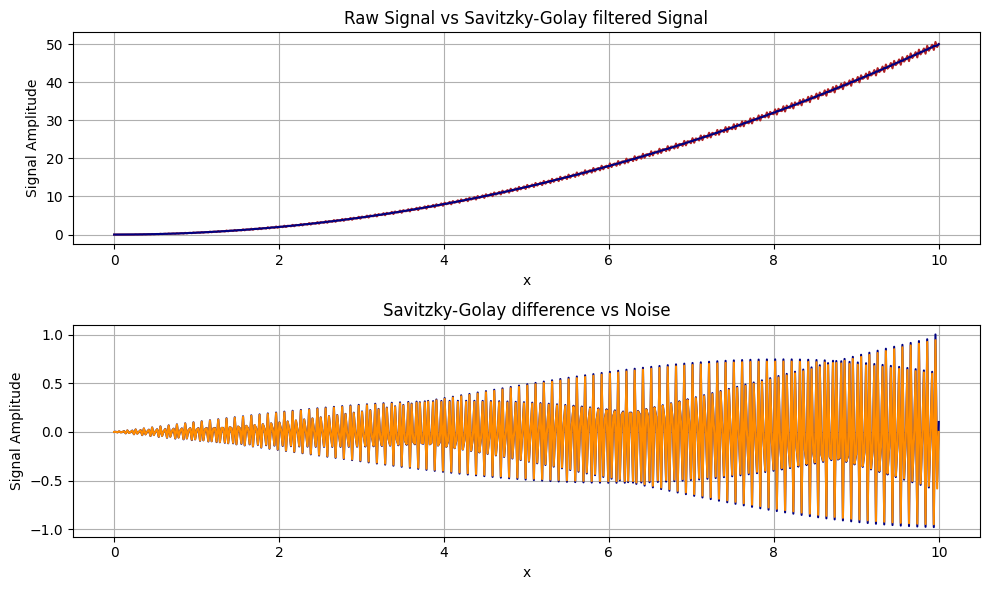

In [6]:
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(x, combined_signal, color='firebrick')
plt.title("Raw Signal vs Savitzky-Golay filtered Signal")
plt.xlabel("x")
plt.ylabel("Signal Amplitude")
plt.plot(x,savgol_filter(combined_signal, 5, 2),color='navy')
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(x, combined_signal-savgol_filter(combined_signal, 7, 4), color='navy')
plt.plot(x,high_freq_disturbance,color='darkorange')
plt.title("Savitzky-Golay difference vs Noise")
plt.xlabel("x")
plt.ylabel("Signal Amplitude")
plt.grid(True)
plt.tight_layout()

用于峰值检测的滚动窗口
现在想象一下，作为一个在整个信号中传播的人，你想检测峰值（我知道，这很奇怪，你得稍微相信我一点）。你开始 “walking” 并看到信号的第一个值 y[0]，然后你把它放在你的背包里。然后你会看到第二个值：y[1]，你把它放在你的背包里。你一直这样一直到窗口大小的点：比如 100。此时，您的背包中有很多历史。 您有 100 个点，您可以使用它们来计算平均值和标准差。 考虑到 mean 和 std，第 101 点是否合理？如果是，则不是峰值。如果没有，那就是一个高峰！

然后你去到点 102，你把从点 1（不是 0!!）到点 101 的平均值和标准视为参考，并对该点进行分类。

现在，如果我找到一个峰值，我是否在平均值和标准中考虑它？我们可以将其设置为一个参数，称为 influence。你可以完全忽略它 influence=0 或全部 influence=1.

我从头开始实现了这个方法（这样我们就可以更好地控制它）。我使用 RealTimePeakDetector（） 生成了一个对象.

In [7]:
import numpy as np

class RealTimePeakDetector:
    """
    Class for real-time peak detection using a thresholding algorithm.
    Peaks are detected by comparing the current value against a rolling mean and standard deviation.
    """
    def __init__(self, data, window_size=None, threshold=2.3, influence=0.5):
        """
        Initialize the peak detector.

        Parameters:
        data (list or np.array): The initial time series data to monitor.
        window_size (int): The number of previous values to consider for the rolling mean and standard deviation.
        threshold (float): The number of standard deviations that the value must exceed to be considered a peak.
        influence (float): A factor (0-1) that determines how much the detected peak affects future statistics.
        """
        self.data = list(data)
        if window_size is None:
            self.window_size = int(len(self.data)/10)
        else:
            self.window_size = window_size
        self.threshold = threshold
        self.influence = influence

        # Initialize lists for tracking signals and filtered values
        self.signals = [0] * len(self.data)  # 1: positive peak, -1: negative peak, 0: no peak
        self.filtered_data = list(self.data)  # Data adjusted based on influence
        self.mean_filter = [0] * len(self.data)
        self.std_filter = [0] * len(self.data)

        # Calculate initial rolling mean and std deviation for the first window
        initial_window = self.data[:self.window_size]
        self.mean_filter[self.window_size - 1] = np.mean(initial_window)
        self.std_filter[self.window_size - 1] = np.std(initial_window)

    def detect_peak(self, new_value):
        """
        Update the signal with a new data point and check if it's a peak.

        Parameters:
        new_value (float): The latest value to add to the data stream.

        Returns:
        int: Signal indicating if the new value is a peak (1 for positive, -1 for negative, 0 for no peak).
        """
        self.data.append(new_value)
        i = len(self.data) - 1

        if i < self.window_size:
            # Not enough data points to start detecting peaks
            return 0

        # Extend arrays for new value
        self.signals.append(0)
        self.filtered_data.append(new_value)
        self.mean_filter.append(0)
        self.std_filter.append(0)

        # Check if the new value deviates from the mean by more than the threshold
        deviation = abs(new_value - self.mean_filter[i - 1])
        if deviation > (self.threshold * self.std_filter[i - 1]):
            # It's a peak (positive or negative)
            if new_value > self.mean_filter[i - 1]:
                self.signals[i] = 1  # Positive peak
            else:
                self.signals[i] = -1  # Negative peak

            # Update the filtered value with influence from the new peak
            self.filtered_data[i] = self.influence * new_value + (1 - self.influence) * self.filtered_data[i - 1]
        else:
            # No peak detected, use raw value
            self.signals[i] = 0
            self.filtered_data[i] = new_value

        # Update rolling mean and std deviation
        self.mean_filter[i] = np.mean(self.filtered_data[(i - self.window_size):i])
        self.std_filter[i] = np.std(self.filtered_data[(i - self.window_size):i])

        return self.signals[i]

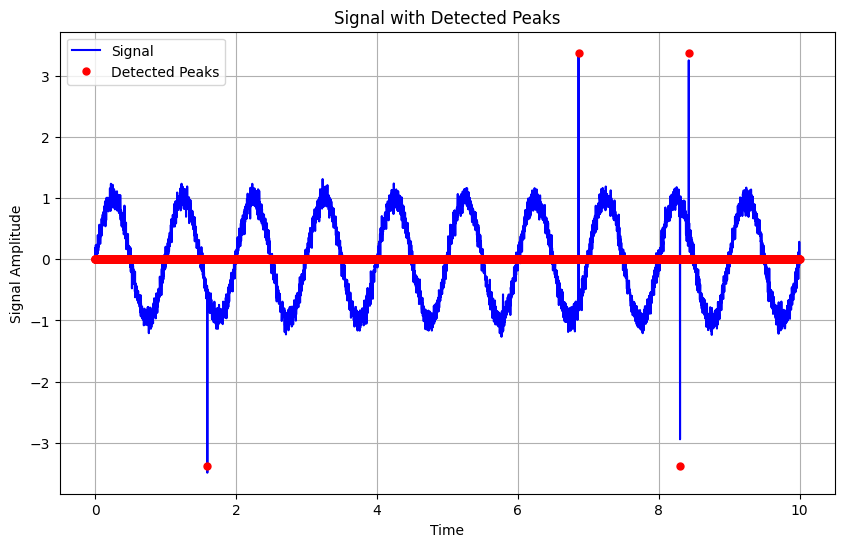

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a synthetic signal with peaks
np.random.seed(42)
size_signal = 5000
time = np.linspace(0, 10, size_signal)
signal = np.sin(2 * np.pi * time) + np.random.normal(0, 0.1, size_signal)
signal = signal*1

random_locs = np.random.randint(size_signal,size=5)

# Add artificial peaks
signal[random_locs[0]] += 4
signal[random_locs[1]] -= 4
signal[random_locs[2]] += 3
signal[random_locs[3]] -= 3

# Instantiate the peak detection class with the following parameters:
# window_size = 30, threshold = 2.5, influence = 0.5
detector = RealTimePeakDetector(signal,threshold=2.5)

# Detect peaks in the signal
signals = []
for i in range(len(signal)):
    signals.append(detector.detect_peak(signal[i]))
signals[0] = 0
# Plot the signal and the detected peaks
plt.figure(figsize=(10, 6))
plt.plot(time, signal, label="Signal", color='blue')
plt.plot(time, np.array(signals) * np.max(signal), 'ro', label="Detected Peaks", markersize=5)
plt.title("Signal with Detected Peaks")
plt.xlabel("Time")
plt.ylabel("Signal Amplitude")
plt.legend()
plt.grid(True)
plt.show()

傅里叶变换的滚动窗口
这可能是最微妙的应用程序，也是最难用几行文字解释的应用程序，所以请对我❤️ 🩹温柔一些。

傅里叶变换 （FFT） 的思想是将信号分解为正弦和余弦分量。此方法将时域信号转换为频域信号。FFT 用于多种任务，例如了解信号的季节性分量、从噪声中清除信号或压缩音频或图像数据.

尽管如此，这种方法有两个臭名昭著的问题：

此方法旨在应用于完全周期性信号。 因此，如果信号是周期性的，则 FFT 能够完美地区分分量。在现实生活中，大多数信号都不是完全周期性的，这种方法有一些泄漏。
FFT 假设每次都存在所有频率分量（在整个信号中）。但想想看，也许有时你每周锻炼 3 次（例如在夏天之前，我们都感到内疚），有时你每周锻炼一次。在现实生活中，频率会随时间变化.
短时傅里叶变换 （STFT） 非常有用，因为它使用滚动窗口来考虑信号的位，使用 Hann 窗口（或类似窗口）施加周期性，并允许您考虑不同时间步的傅里叶变换.

STFT 的结果是一个图像，它为您提供每个时间和频率的组件振幅.

让我们举个例子;让我们考虑一个信号，其频率从 step = 0 到 step = 1000，从 step = 1000 到 step = 2000 的频率要高得多。

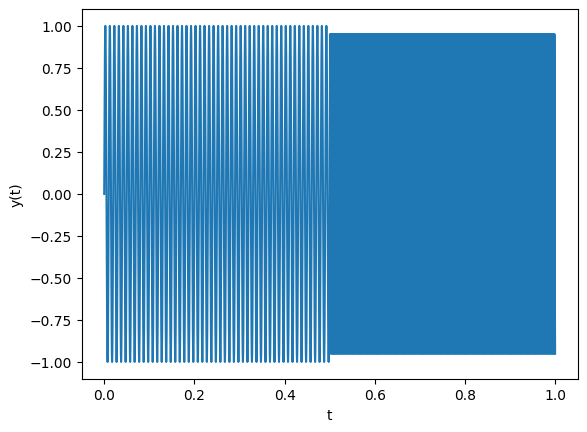

In [10]:
import numpy as np
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

# Signal parameters
T_x = 0.001  # Sampling period (e.g., 1 kHz)
fs = int(1 / T_x)  # Sampling frequency
t = np.linspace(0, 2, 2 * fs, endpoint=False)  # Time vector for 2 seconds
x = np.sin(2 * np.pi * 50 * t[:fs])  # 50 Hz for the first second
x = np.concatenate((x, np.sin(2 * np.pi * 200 * t[fs:])))  # 200 Hz for the second second
t = t/2
N = len(x)
plt.plot(t,x)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.show()


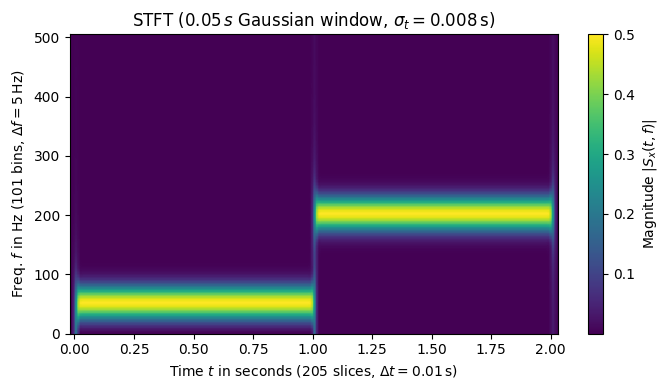

In [11]:

# Create a Gaussian window
g_std = 8  # Standard deviation for Gaussian window in samples
w = gaussian(50, std=g_std, sym=True)  # Symmetric Gaussian window

# ShortTimeFFT parameters
hop = 10  # Hop size
mfft = 200  # FFT size

# Initialize ShortTimeFFT object
SFT = ShortTimeFFT(win=w, hop=hop, fs=fs, mfft=mfft, scale_to='magnitude')

# Perform the STFT on the signal
Sx = SFT.stft(x)

# Plot the STFT result
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Plot the STFT result
plt.figure(figsize=(7, 4))  # enlarge plot a bit
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot

# Set title and labels
plt.title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={g_std*SFT.T}\,$s)")
plt.xlabel(f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)")
plt.ylabel(f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)")
plt.xlim((t_lo, t_hi))

# Plot the magnitude using imshow
plt.imshow(abs(Sx), origin='lower', aspect='auto',
           extent=SFT.extent(N), cmap='viridis')

# Plot the frequency curve (f_i) on top of the STFT plot
# Add a colorbar for magnitude
plt.colorbar(label="Magnitude $|S_x(t, f)|$")


# Add legend

# Show the plot
plt.tight_layout()
plt.show()
